## Perpetrator 分类

In [1]:
import time
import collections

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')

from sklearn.preprocessing import scale
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [2]:
# Display up to 150 rows and columns
pd.set_option('display.max_rows', 220)
pd.set_option('display.max_columns', 150)

# Set the figure size for plots
mpl.rcParams['figure.figsize'] = (14.6, 9.0)

# Set the Seaborn default style for plots
sns.set()

# Set the color palette
sns.set_palette(sns.color_palette("muted"))

### 载入数据

In [3]:
# Load the preprocessed GTD dataset
gtd_df = pd.read_excel("./data/gtd_clean.xlsx")

### Inspect the Structure

The cleansed data frame contains 58 attributes, one of which is used for the data frame index, and 113248 observations.

In [4]:
# Display a summary of the data frame
gtd_df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113175 entries, 0 to 114182
Data columns (total 58 columns):
eventid             113175 non-null int64
iyear               113175 non-null int64
imonth              113175 non-null int64
iday                113175 non-null int64
extended            113175 non-null int64
country             113175 non-null int64
country_txt         113175 non-null object
region              113175 non-null int64
region_txt          113175 non-null object
provstate           113175 non-null object
city                113175 non-null object
latitude            113175 non-null float64
longitude           113175 non-null float64
specificity         113175 non-null int64
vicinity            113175 non-null int64
summary             113175 non-null object
crit1               113175 non-null int64
crit2               113175 non-null int64
crit3               113175 non-null int64
doubtterr           113175 non-null int64
multiple            113175 non-null int6

### Convert Attributes to Correct Data Type

Convert a subset of the data frame attributes to categorical, datatime and string to align with the GTD code book as executed previously in the EDA notebook.

In [5]:
import pickle

with open('./data/gtd_names.json', 'rb') as fp:
    name_dict = pickle.load(fp)  # 载入特征名称


class Bunch(dict):
    '''
    建立树型结构
    '''

    def __init__(self, *args, **kwds):
        super().__init__(*args, **kwds)
        self.__dict__ = self


names = Bunch(name_dict)

In [6]:
# List of attributes that are categorical
cat_attrs = list(names.cat_names)

for cat in cat_attrs:
    gtd_df[cat] = gtd_df[cat].astype('category')

# Data time feature added during EDA
gtd_df['incident_date'] = pd.to_datetime(gtd_df['incident_date'])

# Necessary for label encoding below
gtd_df['gname'] = gtd_df['gname'].astype('str')
    
gtd_df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113175 entries, 0 to 114182
Data columns (total 58 columns):
eventid             113175 non-null int64
iyear               113175 non-null int64
imonth              113175 non-null int64
iday                113175 non-null int64
extended            113175 non-null category
country             113175 non-null category
country_txt         113175 non-null object
region              113175 non-null category
region_txt          113175 non-null object
provstate           113175 non-null object
city                113175 non-null object
latitude            113175 non-null float64
longitude           113175 non-null float64
specificity         113175 non-null category
vicinity            113175 non-null category
summary             113175 non-null object
crit1               113175 non-null category
crit2               113175 non-null category
crit3               113175 non-null category
doubtterr           113175 non-null category
multiple     

In [7]:
gtd_df[list(names.cal_names)].dtypes

nwoundte      int64
nperpcap    float64
nkillter      int64
nkill         int64
nwoundus      int64
nwound      float64
nkillus       int64
dtype: object

In [8]:
gtd_df[list(names.cal_names)] = gtd_df[list(names.cal_names)].astype('int64')

In [9]:
gtd_df.get_dtype_counts()

category          27
datetime64[ns]     1
float64            2
int64             11
object            17
dtype: int64

In [10]:
gtd_df.to_excel('./data/gtd.xlsx')

In [11]:
df = gtd_df.copy()

In [12]:
df[list(names.cat_names)] = df[list(names.cat_names)].astype('int64')

In [13]:
df.to_hdf('./data/gtd.h5', 'GTD')  # 转换为 HDF5 文件
# gtd_df = pd.read_hdf("./data/gtd.h5")

### Find the Major Groups
Get the list of terrorist groups that have 20 or more attacks.

In [14]:
ptt = gtd_df.query('2014 < iyear < 2017')

ex = {'eventid', 'iyear', 'incident_date'} | names.txt_names

ptt = ptt[list(set(ptt.columns)-ex)+['gname']]

In [15]:
ptt.shape

(28391, 39)

In [16]:
# Calculate the number of attacks by group
groups = ptt['gname'].value_counts()
# Include groups with at least 20 attacks
groups = groups[groups > 19]

# Exclude unknown groups
#group_list = groups.index[groups.index != 'Unknown']
group_list = groups.index

# Subset the data to major groups
major_groups = ptt[ptt['gname'].isin(group_list)]
# Display the number of attacks by group
major_groups['gname'].value_counts()

Unknown                                                         12310
Islamic State of Iraq and the Levant (ISIL)                      2662
Taliban                                                          2310
Al-Shabaab                                                        958
Boko Haram                                                        777
Houthi extremists (Ansar Allah)                                   704
Kurdistan Workers' Party (PKK)                                    695
Maoists                                                           541
New People's Army (NPA)                                           493
Tripoli Province of the Islamic State                             325
Palestinian Extremists                                            317
Sinai Province of the Islamic State                               309
Donetsk People's Republic                                         283
Fulani extremists                                                 250
Al-Qaida in the Arab

### Drop Text and Datetime Attributes
Remove the text and datetime attributes, which will not be used in the models.

In [17]:
major_groups.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26919 entries, 73687 to 103285
Data columns (total 39 columns):
INT_MISC        26919 non-null category
country         26919 non-null category
property        26919 non-null category
crit2           26919 non-null category
weaptype1       26919 non-null category
targtype1       26919 non-null category
region          26919 non-null category
guncertain1     26919 non-null category
extended        26919 non-null category
individual      26919 non-null category
crit1           26919 non-null category
INT_ANY         26919 non-null category
multiple        26919 non-null category
nwoundte        26919 non-null int64
ishostkid       26919 non-null category
nperpcap        26919 non-null int64
weapsubtype1    26919 non-null category
longitude       26919 non-null float64
suicide         26919 non-null category
crit3           26919 non-null category
doubtterr       26919 non-null category
vicinity        26919 non-null category
INT_IDEO     

In [18]:
major_groups.get_dtype_counts()

category    27
float64      2
int64        9
object       1
dtype: int64

### Standardize the Numeric Attributes
Adjust for differences in the range of the numeric attributes.

In [19]:
scaler = preprocessing.RobustScaler()

# List of numeric attributes
scale_attrs = list(names.cal_names)

# Standardize the attributes in place
major_groups[scale_attrs] = scaler.fit_transform(major_groups[scale_attrs])

# View the transformation
major_groups[scale_attrs].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
nwoundte,26919.0,0.204577,1.997327,0.0,0.0,0.0,0.0,101.0
nperpcap,26919.0,0.061964,0.779279,0.0,0.0,0.0,0.0,100.0
nkillter,26919.0,0.843976,5.292481,0.0,0.0,0.0,0.0,301.0
nkill,26919.0,0.826795,4.724349,-0.5,-0.5,0.0,0.5,216.0
nwoundus,26919.0,0.007281,0.389158,0.0,0.0,0.0,0.0,48.0
nwound,26919.0,0.970913,4.473223,0.0,0.0,0.0,1.0,500.0
nkillus,26919.0,0.004978,0.296306,0.0,0.0,0.0,0.0,44.0


In [20]:
ptt.get_dtype_counts()

category    27
float64      2
int64        9
object       1
dtype: int64

In [21]:
cat_df = ptt.select_dtypes('category').replace(-1, np.nan)

In [22]:
ptt[list(names.cat_names)] = cat_df

In [23]:
ptt.isnull().sum()

INT_MISC            0
country             0
property         5525
crit2               0
weaptype1       13607
targtype1           0
region           2010
guncertain1         0
extended            0
individual          0
crit1               0
INT_ANY             0
multiple        12887
nwoundte            0
ishostkid           0
nperpcap            0
weapsubtype1      113
longitude           0
suicide          3891
crit3               0
doubtterr           0
vicinity            0
INT_IDEO            0
nkillter            0
nwoundus            0
attacktype1     13607
success          1799
latitude            0
nkillus             0
claimed             0
iday                0
targsubtype1        0
specificity      2209
nkill               0
imonth              0
INT_LOG             0
nwound              0
natlty1           386
gname               0
dtype: int64

In [24]:
np.unique(ptt['INT_ANY'])

array([0, 1], dtype=int64)

### Separate Known and Unknown
Split the major groups into known and unknown.

In [25]:
# Excluded Unknown groups
known_maj_groups = major_groups[ptt['gname'] != "Unknown"]
print("Known Major Groups: {}".format(known_maj_groups.shape))

# Only include Unknown groups
unknown_maj_groups = major_groups[ptt['gname'] == "Unknown"]
print("Unknown Major Groups: {}".format(unknown_maj_groups.shape))

Known Major Groups: (14609, 39)
Unknown Major Groups: (12310, 39)


### Encode the Target Attribute
Convert the text values of the terrorist groups to an encoded numeric value for the random forest models.

In [26]:
# Create the encoder
le = preprocessing.LabelEncoder()

# Fit the encoder to the target
le.fit(known_maj_groups['gname'])

LabelEncoder()

In [27]:
# View the labels
list(le.classes_)

['Abu Sayyaf Group (ASG)',
 'Adan-Abyan Province of the Islamic State',
 'Ahrar al-Sham',
 'Al-Nusrah Front',
 'Al-Qaida in the Arabian Peninsula (AQAP)',
 'Al-Qaida in the Islamic Maghreb (AQIM)',
 'Al-Shabaab',
 'Allied Democratic Forces (ADF)',
 'Anarchists',
 'Ansar al-Dine (Mali)',
 'Ansar al-Sharia (Libya)',
 'Anti-Balaka Militia',
 "Asa'ib Ahl al-Haqq",
 'Baloch Liberation Army (BLA)',
 'Baloch Liberation Front (BLF)',
 'Baloch Republican Army (BRA)',
 'Bangladesh Nationalist Party (BNP)',
 'Bangsamoro Islamic Freedom Movement (BIFM)',
 'Barqa Province of the Islamic State',
 'Boko Haram',
 'Communist Party of India - Maoist (CPI-Maoist)',
 'Communist Party of Nepal - Maoist (CPN-Maoist-Chand)',
 'Democratic Front for the Liberation of Rwanda (FDLR)',
 'Dissident Republicans',
 "Donetsk People's Republic",
 'Free Syrian Army',
 'Fulani extremists',
 'Garo National Liberation Army',
 'Halqa-e-Mehsud',
 'Hamas (Islamic Resistance Movement)',
 'Hizbul Mujahideen (HM)',
 'Houthi ext

In [28]:
# View the encoded values for th terrorist group names
label_codes = le.transform(known_maj_groups['gname'])
label_codes

array([48, 33, 33, ..., 69, 19, 43], dtype=int64)

In [29]:
# Convert some integers into their category names
list(le.inverse_transform([0, 1, 2, 27]))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


['Abu Sayyaf Group (ASG)',
 'Adan-Abyan Province of the Islamic State',
 'Ahrar al-Sham',
 'Garo National Liberation Army']

In [30]:
known_maj_groups.columns

Index(['INT_MISC', 'country', 'property', 'crit2', 'weaptype1', 'targtype1',
       'region', 'guncertain1', 'extended', 'individual', 'crit1', 'INT_ANY',
       'multiple', 'nwoundte', 'ishostkid', 'nperpcap', 'weapsubtype1',
       'longitude', 'suicide', 'crit3', 'doubtterr', 'vicinity', 'INT_IDEO',
       'nkillter', 'nwoundus', 'attacktype1', 'success', 'latitude', 'nkillus',
       'claimed', 'iday', 'targsubtype1', 'specificity', 'nkill', 'imonth',
       'INT_LOG', 'nwound', 'natlty1', 'gname'],
      dtype='object')

In [31]:
known_maj_groups.isnull().sum()

INT_MISC        0
country         0
property        0
crit2           0
weaptype1       0
targtype1       0
region          0
guncertain1     0
extended        0
individual      0
crit1           0
INT_ANY         0
multiple        0
nwoundte        0
ishostkid       0
nperpcap        0
weapsubtype1    0
longitude       0
suicide         0
crit3           0
doubtterr       0
vicinity        0
INT_IDEO        0
nkillter        0
nwoundus        0
attacktype1     0
success         0
latitude        0
nkillus         0
claimed         0
iday            0
targsubtype1    0
specificity     0
nkill           0
imonth          0
INT_LOG         0
nwound          0
natlty1         0
gname           0
dtype: int64

### Create Training and Testing Datasets
The original dataset is split into 80% training and 20% testing.

In [32]:
# Seed for reproducible results
seed = 1009

# Predictor variables
X = pd.get_dummies(known_maj_groups.drop(['gname'], axis=1))

# Labels
y = label_codes

# Create an 80/20 split for training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed, stratify = y)

In [33]:
X.columns

Index(['nwoundte', 'nperpcap', 'longitude', 'nkillter', 'nwoundus', 'latitude',
       'nkillus', 'iday', 'nkill', 'imonth',
       ...
       'natlty1_238', 'natlty1_334', 'natlty1_347', 'natlty1_422',
       'natlty1_603', 'natlty1_999', 'natlty1_1001', 'natlty1_1002',
       'natlty1_1003', 'natlty1_1004'],
      dtype='object', length=611)

### Random Forest Model
Create the model using 1000 estimators.

In [34]:
start = time.time()

# Create the model
rf1 = RandomForestClassifier(n_estimators = 1000, oob_score = True, n_jobs = -1, random_state = seed)

# Fit it to the training data
rf1.fit(X_train, y_train)

end = time.time()
print("Execution Seconds: {}".format((end - start)))
print("\n")
print(rf1)

Execution Seconds: 36.812567949295044


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=True, random_state=1009, verbose=0, warm_start=False)


### Feature Importance
Display the top 50 features by importance in descending order.

In [35]:
# Get the modified column names with one hot encoding
column_names = list(X_train.columns.values)

# Create a descending sorted list of variables by featur importance
var_imp = sorted(zip(map(lambda x: x, rf1.feature_importances_), column_names), 
             reverse = True)

print("\nFeatures Ranking - Top 50:\n")
for f in var_imp[0:50]:
    print(f)


Features Ranking - Top 50:

(0.07556581376712751, 'latitude')
(0.07491175851373802, 'longitude')
(0.03818298659908746, 'country_4')
(0.03239932088153813, 'natlty1_4')
(0.030838213705894617, 'region_10')
(0.02650269690815277, 'natlty1_95')
(0.024319756993083096, 'region_6')
(0.02391132738642055, 'country_95')
(0.021157227173780338, 'INT_IDEO_1')
(0.02068508709349668, 'INT_IDEO_0')
(0.020141988355146988, 'INT_ANY_0')
(0.019815089566115978, 'INT_ANY_1')
(0.019790502355795467, 'region_11')
(0.017976481346633766, 'country_182')
(0.015007941715323526, 'country_209')
(0.014229925913086566, 'natlty1_209')
(0.013883843494325898, 'country_228')
(0.013416131569793727, 'natlty1_228')
(0.012744075398192828, 'iday')
(0.01259389672676876, 'imonth')
(0.01232514956699813, 'natlty1_182')
(0.01171888517520237, 'country_147')
(0.01142582521883928, 'nkill')
(0.010666756704573519, 'INT_LOG_0')
(0.010269123502785905, 'natlty1_147')
(0.010004109877517941, 'INT_IDEO_-1')
(0.009463426317449454, 'INT_LOG_-1')
(

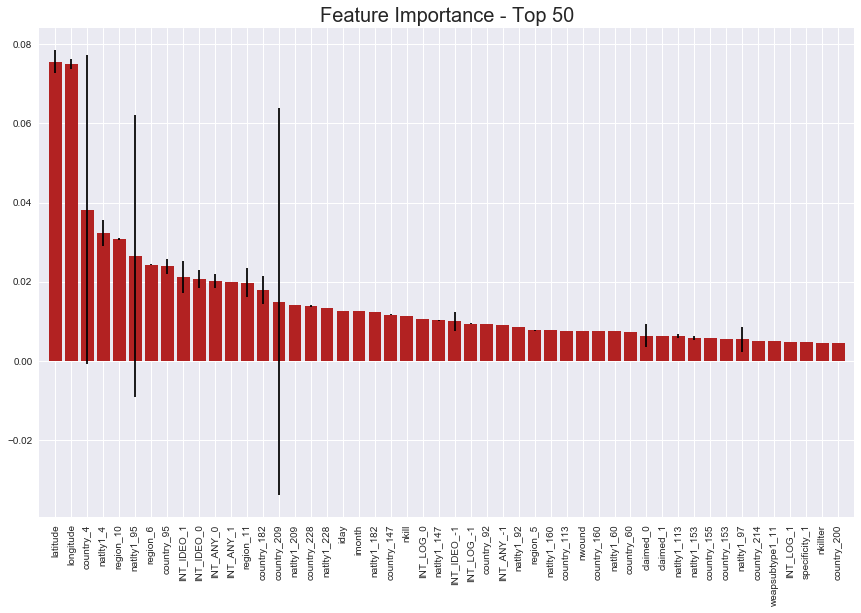

In [36]:
# Get the features, standard deviation and indices
importances = rf1.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf1.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Filter to the top 50
top_n = 50
top_n_importances = importances[indices][0:top_n]
top_n_std = std[0:top_n]
top_n_indices = indices[0:top_n]

# Create a list of x labels
x_labels = [column_names[t] for t in top_n_indices]

# Plot the results
plt.figure()
plt.title("Feature Importance - Top 50",  fontsize=20)
plt.bar(range(top_n), top_n_importances, color="firebrick", yerr = top_n_std, align="center")
plt.xticks(rotation=90)
plt.xticks(range(top_n), x_labels)
plt.xlim([-1, top_n])
plt.show()

In [37]:
# Predict labels on the test dataset
pred_labels1 = rf1.predict(X_test)

# Calculate the accuracy of the model
acc_score1 = accuracy_score(y_test, pred_labels1)
print("\nAccuracy: {}".format(acc_score1))

# Calculate the precision of the model
prec_score1 = precision_score(y_test, pred_labels1, average='weighted')
print("\nPrecision: {}".format(prec_score1))

# Calculate the recall of the model
rcll_score1 = recall_score(y_test, pred_labels1, average='weighted')
print("\nRecall: {}".format(rcll_score1))

# Calculate the F1 of the model
f1_score1 = f1_score(y_test, pred_labels1, average='weighted')
print("\nF1: {}".format(f1_score1))


Accuracy: 0.945242984257358

Precision: 0.9440370275506761

Recall: 0.945242984257358

F1: 0.939687110757136


### Apply Model to Uknown Groups
Of the 106,544 observations, 56.25% have a group classification of Unknown.

In [39]:
# Predictor variables
X_unknown = pd.get_dummies(unknown_maj_groups.drop(['gname'], axis=1))


# Predict labels on the unknown dataset
pred_labels2 = rf1.predict(X_unknown)

# Get the list of predicted labels for unknown observations
unknown_preds = list(le.inverse_transform(pred_labels2))

# Calculate the counts for each group
unknown_counts = collections.Counter(unknown_preds)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### Top 25 Predicted Unknown Groups
The top 25 predicted groups account for 97.59% of the unknown observations.

In [40]:
# Top 25 unknown
unknown_top25 = pd.DataFrame(unknown_counts.most_common()[0:25], columns=['Group', 'Attacks'])

cumsum = 0

# Display the top 25 groups with counts
for index, row in unknown_top25.iterrows():
    print("{} : {}".format(row['Group'], row['Attacks']))
    cumsum += row['Attacks']


print("\nTop 25 Account For: {}%".format((cumsum / X_unknown.shape[0])*100))

Muslim extremists : 8218
Taliban : 1087
Maoists : 1001
Separatists : 916
Fulani extremists : 328
Tribesmen : 323
Anarchists : 282
Al-Shabaab : 75
Dissident Republicans : 47
Jihadi-inspired extremists : 28
Boko Haram : 2
Kurdistan Workers' Party (PKK) : 1
Islamic State of Iraq and the Levant (ISIL) : 1
Abu Sayyaf Group (ASG) : 1

Top 25 Account For: 100.0%


### Muslim Extremists
Almost half of the predicted unknown group observations are Muslim extremists.

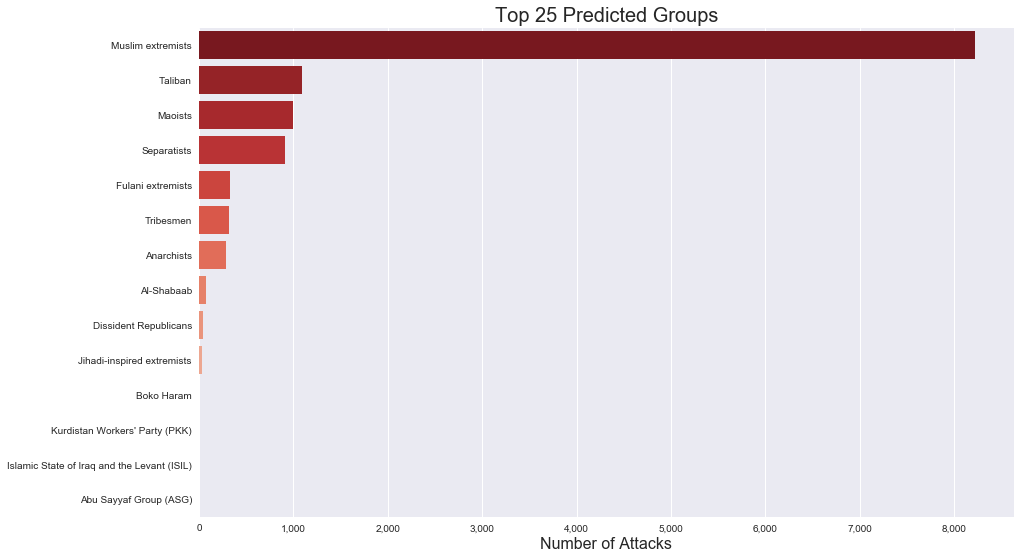

In [41]:
# Set the color palette in reverse
colors = sns.color_palette('Reds', len(unknown_top25))
colors.reverse()
plt.figure(figsize=(14.6, 9.0))

# Plot bar chart with index as y values
ax = sns.barplot(unknown_top25.Attacks, unknown_top25.index, orient='h', palette=colors)
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# Reset the y labels
ax.set_yticklabels(unknown_top25.Group)
ax.set_xlabel(xlabel='Number of Attacks', fontsize=16)
ax.set_title(label='Top 25 Predicted Groups', fontsize=20)
plt.show();

In [44]:
gtd_df.query('eventid==201701090030')

,eventid,iyear,imonth,iday,extended,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,summary,crit1,crit2,crit3,doubtterr,multiple,success,suicide,attacktype1,attacktype1_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,gname,guncertain1,individual,nperpcap,claimed,weaptype1,weaptype1_txt,weapsubtype1,weapsubtype1_txt,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,ishostkid,scite1,scite2,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,incident_date
103532,201701090030,2017,1,9,0,95,Iraq,10,Middle East & North Africa,Babil,Hillah,32.469238,44.416637,1,1,01/09/2017: Approximately 20 explosives device...,1,1,1,0,0,0,0,3,Bombing/Explosion,15,Religious Figures/Institutions,87,Affiliated Institution,Sharifa Bint al-Hassan Shrine,Shrine,95,Iraq,Unknown,0,0,0,0,6,Explosives,16,Unknown Explosive Type,0,0,0,0,0,0,0,0,"""Security forces find 20 IED on road to religi...",Unknown,START Primary Collection,-1,-1,0,-1,2017-01-09


In [45]:
pet = [
    '201701090031', '201702210037', '201703120023', '201705050009',
    '201705050010', '201707010028', '201707020006', '201708110018',
    '201711010006', '201712010003'
]

In [46]:
pet

['201701090031',
 '201702210037',
 '201703120023',
 '201705050009',
 '201705050010',
 '201707010028',
 '201707020006',
 '201708110018',
 '201711010006',
 '201712010003']

In [48]:
gtd_df.query('eventid==201701090031')

,eventid,iyear,imonth,iday,extended,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,summary,crit1,crit2,crit3,doubtterr,multiple,success,suicide,attacktype1,attacktype1_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,gname,guncertain1,individual,nperpcap,claimed,weaptype1,weaptype1_txt,weapsubtype1,weapsubtype1_txt,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,ishostkid,scite1,scite2,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,incident_date
103533,201701090031,2017,1,9,0,95,Iraq,10,Middle East & North Africa,Saladin,Tikrit,35.0325,43.646389,1,1,01/09/2017: An explosive device detonated near...,1,1,1,0,0,1,0,3,Bombing/Explosion,14,Private Citizens & Property,67,Unnamed Civilian/Unspecified,Not Applicable,Civilians,95,Iraq,Unknown,0,0,0,0,6,Explosives,16,Unknown Explosive Type,15,0,0,0,0,0,0,0,"""Bomb blast kills 15 persons while fleeing eas...",Unknown,START Primary Collection,-1,-1,0,-1,2017-01-09


In [59]:
pet_df = gtd_df[gtd_df['eventid'].isin(pet)][unknown_maj_groups.columns.tolist()]

In [61]:
# Predictor variables
X_unknown = pd.get_dummies(pet_df.drop(['gname'], axis=1))


# Predict labels on the unknown dataset
pred_labels2 = rf1.predict(X_unknown)

# Get the list of predicted labels for unknown observations
unknown_preds = list(le.inverse_transform(pred_labels2))

# Calculate the counts for each group
unknown_counts = collections.Counter(unknown_preds)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [66]:
X_unknown

,nwoundte,nperpcap,longitude,nkillter,nwoundus,latitude,nkillus,iday,nkill,imonth,nwound,INT_MISC_-1,INT_MISC_0,INT_MISC_1,country_4,country_5,country_6,country_8,country_11,country_12,country_14,country_15,country_16,country_17,country_18,country_19,country_21,country_22,country_25,country_26,country_28,country_30,country_32,country_33,country_34,country_35,country_36,country_37,country_38,country_41,country_42,country_43,country_44,country_45,country_47,country_49,country_50,country_51,country_53,country_54,country_55,country_56,country_58,country_59,country_60,country_62,country_63,country_64,country_65,country_67,country_68,country_69,country_72,country_73,country_74,country_75,country_76,country_78,country_83,country_84,country_85,country_86,country_87,country_88,country_89,...,natlty1_149,natlty1_151,natlty1_152,natlty1_153,natlty1_155,natlty1_156,natlty1_157,natlty1_158,natlty1_159,natlty1_160,natlty1_161,natlty1_162,natlty1_163,natlty1_164,natlty1_166,natlty1_167,natlty1_168,natlty1_173,natlty1_174,natlty1_175,natlty1_176,natlty1_177,natlty1_178,natlty1_179,natlty1_180,natlty1_181,natlty1_182,natlty1_183,natlty1_184,natlty1_185,natlty1_186,natlty1_190,natlty1_192,natlty1_195,natlty1_197,natlty1_198,natlty1_199,natlty1_200,natlty1_201,natlty1_202,natlty1_203,natlty1_204,natlty1_205,natlty1_207,natlty1_208,natlty1_209,natlty1_210,natlty1_212,natlty1_213,natlty1_214,natlty1_215,natlty1_216,natlty1_217,natlty1_218,natlty1_219,natlty1_221,natlty1_222,natlty1_223,natlty1_225,natlty1_228,natlty1_229,natlty1_230,natlty1_231,natlty1_233,natlty1_235,natlty1_238,natlty1_334,natlty1_347,natlty1_422,natlty1_603,natlty1_999,natlty1_1001,natlty1_1002,natlty1_1003,natlty1_1004
103533,0,0,43.646389,0,0,35.032500,0,9,15,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
104775,10,0,65.903198,10,0,32.656200,0,21,14,2,15,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
105390,0,0,30.987207,0,0,8.650116,0,12,23,3,56,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
106967,0,0,31.828492,0,0,5.561641,0,5,15,5,8,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
106968,0,0,31.828492,0,0,5.561641,0,5,15,5,7,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
109039,0,0,19.180971,0,0,6.997777,0,1,15,7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
109049,0,0,36.292084,1,0,33.515244,0,2,21,7,12,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
110

In [62]:
unknown_counts

Counter({'Muslim extremists': 4, 'Taliban': 3, 'Fulani extremists': 3})

In [63]:
unknown_preds

['Muslim extremists',
 'Taliban',
 'Muslim extremists',
 'Fulani extremists',
 'Fulani extremists',
 'Fulani extremists',
 'Muslim extremists',
 'Taliban',
 'Taliban',
 'Muslim extremists']

In [67]:
var_imp

[(0.07556581376712751, 'latitude'),
 (0.07491175851373802, 'longitude'),
 (0.03818298659908746, 'country_4'),
 (0.03239932088153813, 'natlty1_4'),
 (0.030838213705894617, 'region_10'),
 (0.02650269690815277, 'natlty1_95'),
 (0.024319756993083096, 'region_6'),
 (0.02391132738642055, 'country_95'),
 (0.021157227173780338, 'INT_IDEO_1'),
 (0.02068508709349668, 'INT_IDEO_0'),
 (0.020141988355146988, 'INT_ANY_0'),
 (0.019815089566115978, 'INT_ANY_1'),
 (0.019790502355795467, 'region_11'),
 (0.017976481346633766, 'country_182'),
 (0.015007941715323526, 'country_209'),
 (0.014229925913086566, 'natlty1_209'),
 (0.013883843494325898, 'country_228'),
 (0.013416131569793727, 'natlty1_228'),
 (0.012744075398192828, 'iday'),
 (0.01259389672676876, 'imonth'),
 (0.01232514956699813, 'natlty1_182'),
 (0.01171888517520237, 'country_147'),
 (0.01142582521883928, 'nkill'),
 (0.010666756704573519, 'INT_LOG_0'),
 (0.010269123502785905, 'natlty1_147'),
 (0.010004109877517941, 'INT_IDEO_-1'),
 (0.00946342631

### References

Albon, C. (2017). Convert Pandas categorical data for scikit-learn Retrieved from https://chrisalbon.com/machine_learning/preprocessing_structured_data/convert_pandas_categorical_column_into_integers_for_scikit-learn/

Keen, B. (2017). Feature scaling with scikit-learn Retrieved from http://benalexkeen.com/feature-scaling-with-scikit-learn/

Saabas, A. (2014). Selecting good features – Part III: random forests Retrieved from http://blog.datadive.net/selecting-good-features-part-iii-random-forests/

scikit-learn. (n.d.). Feature importances with forests of trees Retrieved from http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py